In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import rl_equation_solver
from rl_equation_solver.environment.algebraic import Env
from rl_equation_solver.agent.dqn import Agent as AgentDQN
from rl_equation_solver.agent.gcn import Agent as AgentGCN
from rl_equation_solver.agent.lstm import Agent as AgentLSTM
from rl_equation_solver.utilities import utilities
from rl_equation_solver.utilities.utilities import GraphEmbedding
import networkx as nx
import numpy as np
from torch_geometric.utils.convert import from_networkx
import matplotlib.pyplot as plt
from rex import init_logger
from stable_baselines3 import DQN, A2C, PPO
from stable_baselines3.common.evaluation import evaluate_policy
from gymnasium import spaces
from gymnasium.vector.utils.spaces import batch_space
from stable_baselines3.common.env_checker import check_env
from sympy import symbols
from rl_equation_solver.utilities.history import History
import torch
from sympy import parse_expr

In [3]:
# plot reward distribution
def plot_reward_dist(env):
    _, ax = plt.subplots(1, 1)
    ax.hist(env.best_history['reward'])
    ax.set_ylabel('Count')
    ax.set_xlabel('Reward')
    plt.show()

# plot complexity, loss, reward
def plot_trends(env):
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    ax = axes.flatten()
    history = env.total_history
    x = np.arange(len(history['ep']))
    
    y = history['complexity']
    a, b = np.polyfit(x, y, 1)
    ax[0].scatter(x, y)
    ax[0].plot(a*x + b, color='r')
    
    y = history['loss']
    mask = np.array([i for i, v in enumerate(y) if not np.isnan(v)])
    mask = slice(mask[0], mask[-1] + 1)
    a, b = np.polyfit(x[mask], y[mask], 1)
    ax[1].scatter(x[mask], y[mask])
    ax[1].plot(x[mask], a*x[mask] + b, color='r')
    
    y = history['reward']
    a, b = np.polyfit(x, y, 1)
    ax[2].scatter(x, y)
    ax[2].plot(a*x + b, color='r')

    y = history['loop_step']
    a, b = np.polyfit(x, y, 1)
    ax[3].scatter(x, y)
    ax[3].plot(a*x + b, color='r')
    
    ax[0].set_title('Complexity')
    ax[1].set_title('Loss')
    ax[2].set_title('Reward')
    ax[3].set_title('Steps')

    
    plt.show()
    

In [4]:
init_logger(__name__, log_level='DEBUG')
init_logger('rl_equation_solver', log_level="DEBUG")

<Logger rl_equation_solver (DEBUG)>

In [5]:
env = Env(order=2)

INFO - 2023-04-21 14:38:13,106 [algebraic.py:106] : Initializing environment with order=2, |S| = 11 x 128 = 1408
INFO - 2023-04-21 14:38:13,106 [algebraic.py:109] : Using reward function: diff_loss_reward.


In [6]:
check_env(env, warn=True)

DEBUG - 2023-04-21 14:38:13,516 [algebraic.py:443] : {'ep': '0   ', 'step': '0   ', 'loop_step': '0   ', 'complexity': '1.60e+01 ', 'loss': 'nan      ', 'reward': '-7.00e+00', 'state': '0              ', 'next_state': '0              '}
DEBUG - 2023-04-21 14:38:13,549 [algebraic.py:443] : {'ep': '0   ', 'step': '1   ', 'loop_step': '1   ', 'complexity': '1.40e+01 ', 'loss': 'nan      ', 'reward': '2.00e+00 ', 'state': '0              ', 'next_state': '0              '}
DEBUG - 2023-04-21 14:38:13,583 [algebraic.py:443] : {'ep': '0   ', 'step': '2   ', 'loop_step': '2   ', 'complexity': '9.00e+00 ', 'loss': 'nan      ', 'reward': '-8.00e+00', 'state': '0              ', 'next_state': '0              '}
DEBUG - 2023-04-21 14:38:13,614 [algebraic.py:443] : {'ep': '0   ', 'step': '3   ', 'loop_step': '3   ', 'complexity': '1.80e+01 ', 'loss': 'nan      ', 'reward': '-9.00e+00', 'state': '0              ', 'next_state': '-1             '}
DEBUG - 2023-04-21 14:38:13,656 [algebraic.py:443] :

In [7]:
model = DQN("MlpPolicy", env, verbose=1)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [8]:
model.tau = 0.005

In [9]:
model.set_env(env)
model.learn(total_timesteps=int(10000))

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
DEBUG - 2023-04-21 14:38:21,227 [algebraic.py:443] : {'ep': '0   ', 'step': '11  ', 'loop_step': '0   ', 'complexity': '1.30e+01 ', 'loss': 'nan      ', 'reward': '-4.00e+00', 'state': '0              ', 'next_state': '0**a0          '}
DEBUG - 2023-04-21 14:38:21,265 [algebraic.py:443] : {'ep': '0   ', 'step': '12  ', 'loop_step': '1   ', 'complexity': '1.70e+01 ', 'loss': 'nan      ', 'reward': '-4.00e+00', 'state': '0**a0          ', 'next_state': '(0**a0)**a1    '}
DEBUG - 2023-04-21 14:38:21,295 [algebraic.py:443] : {'ep': '0   ', 'step': '13  ', 'loop_step': '2   ', 'complexity': '2.10e+01 ', 'loss': 'nan      ', 'reward': '-4.00e+00', 'state': '(0**a0)**a1    ', 'next_state': '((0**a0)**a1)**a1'}
DEBUG - 2023-04-21 14:38:21,326 [algebraic.py:443] : {'ep': '0   ', 'step': '14  ', 'loop_step': '3   ', 'complexity': '2.50e+01 ', 'loss': 'nan      ', 'reward': '-4.00e+00', 'state': '((0**a0)**a1)**a1', 'nex

In [ ]:
obs = model.replay_buffer.sample(64)

In [14]:
env.state_string

0

In [28]:
env.state_string = parse_expr('0')

In [29]:
env.state_vec

array([-8.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
      dtype=float32)

In [30]:
model.q_net(torch.tensor([env.state_vec], device='cuda:0'))

tensor([[ 0.0101,  0.0445, -0.1193,  0.1076, -0.1003,  0.0163, -0.0057, -0.0049,
          0.0016,  0.0630,  0.1156]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [12]:
env.actions

[[<function _operator.add(a, b, /)>, a0],
 [<function _operator.add(a, b, /)>, a1],
 [<function _operator.add(a, b, /)>, 1],
 [<function _operator.sub(a, b, /)>, a0],
 [<function _operator.sub(a, b, /)>, a1],
 [<function _operator.sub(a, b, /)>, 1],
 [<function _operator.truediv(a, b, /)>, a0],
 [<function _operator.truediv(a, b, /)>, a1],
 [<function _operator.truediv(a, b, /)>, 1],
 [<function _operator.pow(a, b, /)>, a0],
 [<function _operator.pow(a, b, /)>, a1]]

In [37]:
obs.observations

tensor([[-2., -8., -9.,  ...,  0.,  0.,  0.],
        [-8.,  0.,  0.,  ...,  0.,  0.,  0.],
        [-8.,  0.,  0.,  ...,  0.,  0.,  0.],
        ...,
        [-2., -8., -9.,  ...,  0.,  0.,  0.],
        [-2., -8., -6.,  ...,  0.,  0.,  0.],
        [-2., -8., -9.,  ...,  0.,  0.,  0.]], device='cuda:0')

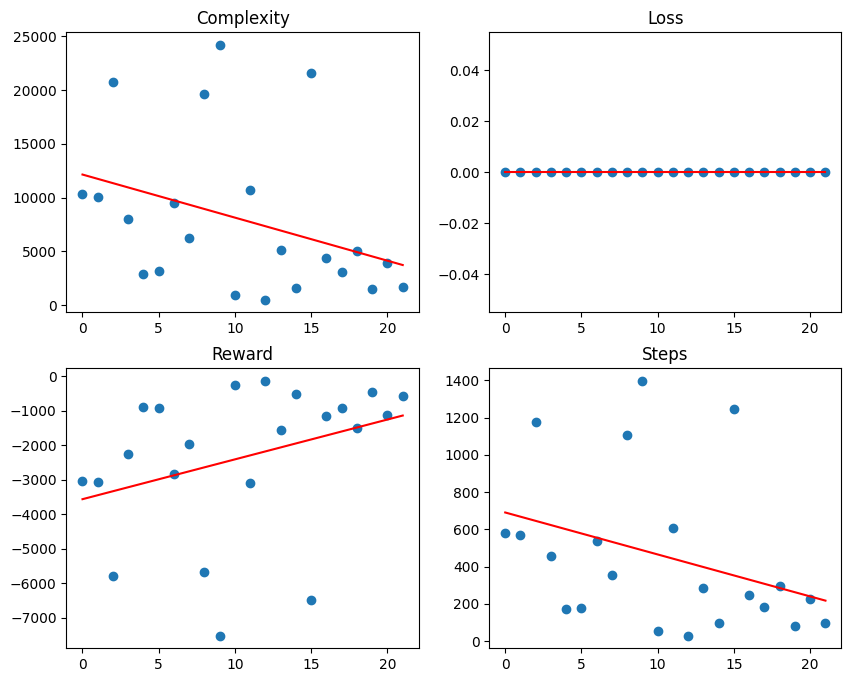

In [10]:
plot_trends(env)